<h1>Signal Processing</h1>

This isn't a fully functioning notebook. I did a lot of cutting, which I assume broke a few cells, so just look at the pretty things and be happy.

In [1]:
# let's get this out of the way
%matplotlib inline
import numpy as np
from numpy import genfromtxt
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt

Load my data and plot a chunk of it to get a feel for what we're looking at.

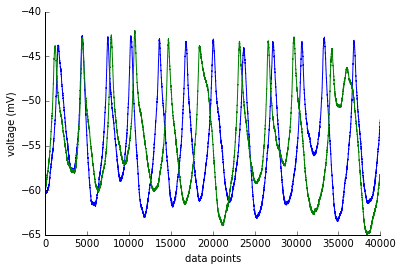

In [38]:
# %timeit of import: 4.04s for a 28MB file. Over twice as fast as MATLAB
SOP_data = genfromtxt('/Users/chadestep/My_Stuff/PYTHON/example_data/2015_02_25_0003_data.csv', 
                      delimiter=',')

f, ax = plt.subplots(1)
ax.plot(SOP_data[:40000,:2])
ax.set_xlabel('data points')
ax.set_ylabel('voltage (mV)')
simpleaxis(ax)

In [39]:
# I'm leaving out the documentation for the time being. 
# The script with full documentation is in my 'playing_with_python'
# repository, and I'll add it in here later

def step_window(array, window, step):
    if array.ndim < 2:
        array = array.reshape(len(array), 1)
        columns = 1
    else:
        columns = array.shape[1]
    rows = array.shape[0]
    new_x, new_y = columns, window
    new_z = int(1 + ((rows - window) / step))
    new_array = np.empty([new_y, new_x, new_z])
    for x in range(new_z):
        new_array[:,:,x] = array[(0 + step * x):(window + step * x)]
    return new_array

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [40]:
# timeit: 110ms
SOP_epochs = step_window(SOP_data, 2**15, 10**4)
print(SOP_epochs.shape)

(32768, 5, 67)


In [41]:
# Now I just need to run a periodogram on each column of data (and
# keep said data in the proper shaped array)

# timeit: 431ms
fs = 10**4
SOP_f, SOP_den = sp.signal.periodogram(SOP_epochs.T, fs)
SOP_den = SOP_den.T
print(SOP_den.shape)

(16385, 5, 67)


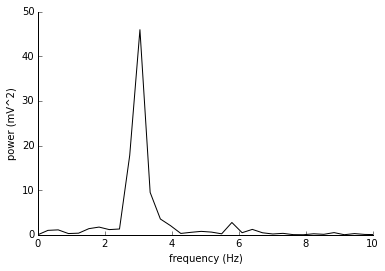

In [46]:
# An example trace. I'm only plotting out to 10Hz since that's the 
# biologically relevent range for these experiments
f, ax = plt.subplots(1)
ax.plot(SOP_f, SOP_den[:,0,0], color='black')
ax.set_xlim(0,10)
ax.set_ylim(0,50)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('power (mV^2)')
simpleaxis(ax)

In [13]:
# Now I just need to take the sum of the power from 0-~10Hz for each
# (note: based on the transform length, the resolution is ~0.305Hz)
variance = SOP_den[0:33,:,:]
variance = np.sum(variance,axis=0)

In [14]:
variance.T.shape

(67, 5)

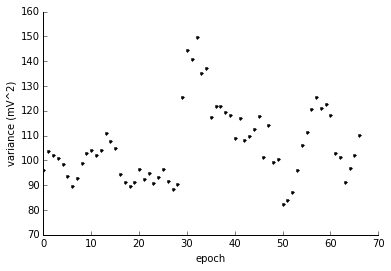

In [47]:
# a quick plot to visualize the first sweep.

f, ax = plt.subplots(1)
ax.plot(variance.T[:,0], marker='.', color='black', linestyle='None')
ax.set_xlabel('epoch')
ax.set_ylabel('variance (mV^2)')
ax.set_ylim(70,160)
simpleaxis(ax)

In [60]:
freq_density = SOP_den[:20,0,:]
x = np.array(SOP_f[:20])
X = np.zeros((freq_density.shape[1], freq_density.shape[0])) + x
y = np.arange(freq_density.shape[1])
Y = np.zeros((freq_density.shape[0], freq_density.shape[1])) + y

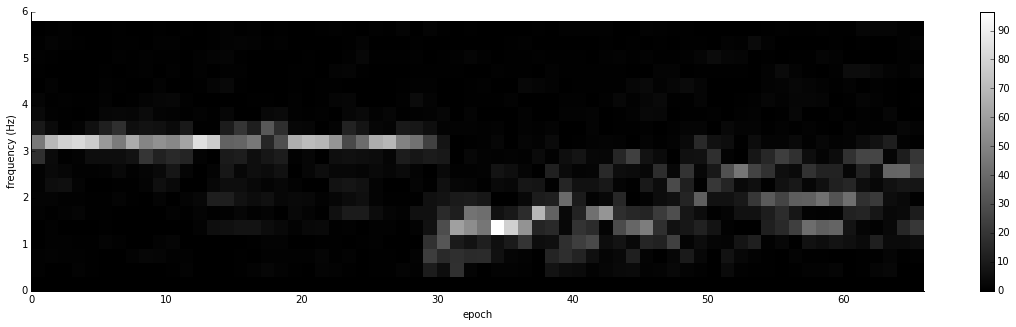

In [58]:
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(111)
f = plt.pcolormesh(Y, X.T, freq_density, cmap=plt.cm.gray)
plt.colorbar(f)
plt.xlim(0,66)
plt.xlabel('epoch')
plt.ylabel('frequency (Hz)')
simpleaxis(ax)
plt.show()

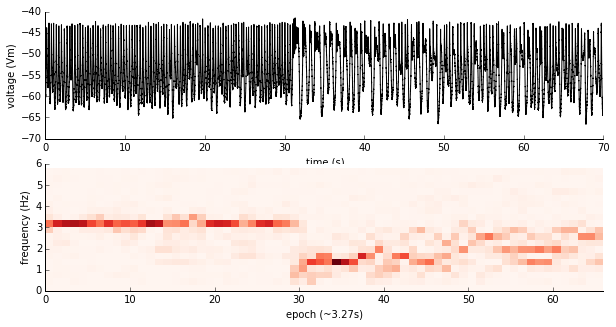

In [62]:
# note: cmap 'bone', 'Reds', 'summer', and 'binary' all nice options

f, (ax1,ax2) = plt.subplots(2, sharex=False, sharey=False, figsize=(10,5))
end = len(SOP_data[:,0])

ax1.plot(np.arange(0,70,0.0001), SOP_data[:,0], color='black', linewidth=1.0)
simpleaxis(ax1)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('voltage (Vm)')

ax2.pcolormesh(Y, X.T, freq_density, 
               cmap=plt.cm.Reds)
simpleaxis(ax2)
ax2.set_xlim(left=0, right=66)
ax2.set_xlabel('epoch (~3.27s)')
ax2.set_ylabel('frequency (Hz)')

# f.savefig('2015_02_25_0003_sweep1.svg')

In [24]:
import pandas as pd

sop_var = pd.read_excel('./Data and Figures/GABAB - SOPs/GABAB SOP pandas.xlsx', 
                       sheetname='SOP variance')
sop_volt = pd.read_excel('./Data and Figures/GABAB - SOPs/GABAB SOP pandas.xlsx', 
                       sheetname='SOP voltage')

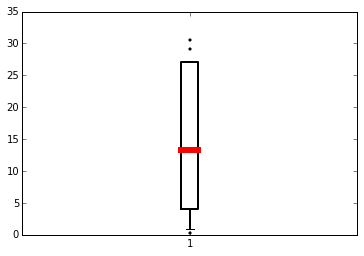

In [27]:
# import seaborn as sns
# sns.set_style('whitegrid')

# make it look pretty
whis=[10,90]
boxprops = dict(linestyle='-',
                linewidth=2, 
                color='black')
medianprops = dict(linestyle='-', 
                   linewidth=6, 
                   color='red')
flierprops = dict(marker='.', 
                  markerfacecolor='black', 
                  markeredgecolor='black', 
                  markersize=5,
                  linestyle='none')
whiskerprops = dict(linestyle='-', 
                    linewidth=2, 
                    color='black')

# data = sop_var.ix[:,0:3].dropna()

data = sop_var['apamin_high']

plt.boxplot(data,
            widths=0.05, 
            whis=whis, 
            whiskerprops=whiskerprops, 
            boxprops=boxprops, 
            medianprops=medianprops, 
            flierprops=flierprops)

plt.show()

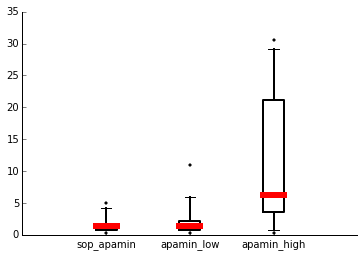

In [28]:
df = sop_var.ix[:,0:3].dropna()

fig, ax = plt.subplots()
for n, col in enumerate(df.columns):
    ax.boxplot(df[col], 
               positions=[n], 
               widths=0.25, 
               whis=whis, 
               whiskerprops=whiskerprops,             
               boxprops=boxprops, 
               medianprops=medianprops, 
               flierprops=flierprops)

ax.set_xticks(range(n+1))
ax.set_xticklabels(cols[0:3])
ax.set_xlim(-1, n+1)
simpleaxis(ax)

plt.show()

In [30]:
from scipy import stats  

# need to make sure to drop any NaNs (will throw off stats)

z_stat, p_val = stats.wilcoxon(sop_var.sop_apamin.dropna(), 
                               sop_var.apamin_low.dropna())
print('Wilcoxon signed-rank test p for treatments 1 and 2 =', p_val)

Wilcoxon signed-rank test p for treatments 1 and 2 = 0.138640633813


/Users/chadestep/anaconda/lib/python3.4/site-packages/scipy/stats/morestats.py:2060: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [31]:
t_stat, p_val = stats.ttest_ind(sop_var.sop_apamin.dropna(), 
                                sop_var.apamin_low.dropna())
print('t-test p for treatments 1 and 2 =', p_val)

t-test p for treatments 1 and 2 = 0.456084879182
